# Lab3 ResNet18

In [1]:
import os
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device=torch.device('cuda',0)
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import copy
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

1.4.0
True


## DataSet & DataLoader
data augmentation:  
1. RandomHorizontalFlip
2. RandomVerticalFilp
3. Normalize each channel(R,G,B)

In [3]:
class RetinopathyDataSet(Dataset):
    def __init__(self, img_path, mode):
        """
        Args:
            img_path: Root path of the dataset.
            mode: training/testing
            
            self.img_names (string list): String list that store all image names.
            self.labels (int or float list): Numerical list that store all ground truth label values.
        """
        self.img_path = img_path
        self.mode = mode
        
        self.img_names=np.squeeze(pd.read_csv('train_img.csv' if mode=='train' else 'test_img.csv').values)
        self.labels=np.squeeze(pd.read_csv('train_label.csv' if mode=='train' else 'test_label.csv').values)
        assert len(self.img_names)==len(self.labels),'length not the same'
        self.data_len=len(self.img_names)
        
        self.transformations=transforms.Compose([transforms.CenterCrop((390,390)),transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip(),transforms.ToTensor()])
        print(f'>> Found {self.data_len} images...')
        
    def __len__(self):
        return self.data_len

    def __getitem__(self, index):
        single_img_name=os.path.join(self.img_path,self.img_names[index]+'.jpeg')
        single_img=Image.open(single_img_name)  # read an PIL image
        img=self.transformations(single_img)
        label=self.labels[index]
        
        return img, label

## Model
1. ResNet18 (with/wo pretrained weights)
2. ResNet50 (with/wo pretrained weights)

reference: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#initialize-and-reshape-the-networks  

In [4]:
class ResNet18(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet18,self).__init__()
        self.model=models.resnet18(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out
    
class ResNet50(nn.Module):
    def __init__(self,num_class,pretrained=False):
        """
        Args:
            num_class: #target class
            pretrained: 
                True: the model will have pretrained weights, and only the last layer's 'requires_grad' is True(trainable)
                False: random initialize weights, and all layer's 'require_grad' is True
        """
        super(ResNet50,self).__init__()
        self.model=models.resnet50(pretrained=pretrained)
        if pretrained:
            for param in self.model.parameters():
                param.requires_grad=False
        num_neurons=self.model.fc.in_features
        self.model.fc=nn.Linear(num_neurons,num_class)
        
    def forward(self,X):
        out=self.model(X)
        return out

## Train & Evaluate

In [5]:
def train(model,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,name):
    """
    Args:
        model: resnet model
        loader_train: training dataloader
        loader_test: testing dataloader
        Loss: loss function
        optimizer: optimizer
        epochs: number of training epoch
        device: gpu/cpu
        num_class: #target class
        name: model name when saving model
    Returns:
        dataframe: with column 'epoch','acc_train','acc_test'
    """
    df=pd.DataFrame()
    df['epoch']=range(1,epochs+1)
    best_model_wts=None
    best_evaluated_acc=0
    
    model.to(device)
    acc_train=list()
    acc_test=list()
    for epoch in range(1,epochs+1):
        """
        train
        """
        with torch.set_grad_enabled(True):
            model.train()
            total_loss=0
            correct=0
            for images,targets in loader_train:
                images,targets=images.to(device),targets.to(device,dtype=torch.long)
                predict=model(images)
                loss=Loss(predict,targets)
                total_loss+=loss.item()
                correct+=predict.max(dim=1)[1].eq(targets).sum().item()
                """
                update
                """
                optimizer.zero_grad()
                loss.backward()  # bp
                optimizer.step()
            total_loss/=len(loader_train.dataset)
            acc=100.*correct/len(loader_train.dataset)
            acc_train.append(acc)
            print(f'epoch{epoch:>2d} loss:{total_loss:.4f} acc:{acc:.2f}%')
        """
        evaluate
        """
        _,acc=evaluate(model,loader_test,device,num_class)
        acc_test.append(acc)
        # update best_model_wts
        if acc>best_evaluated_acc:
            best_evaluated_acc=acc
            best_model_wts=copy.deepcopy(model.state_dict())
    
    df['acc_train']=acc_train
    df['acc_test']=acc_test
    
    # save model
    torch.save(best_model_wts,os.path.join('experiment models',name+'.pt'))
    
    return df

In [6]:
def evaluate(model,loader_test,device,num_class):
    """
    Args:
        model: resnet model
        loader_test: testing dataloader
        device: gpu/cpu
        num_class: #target class
    Returns:
        confusion_matrix: (num_class,num_class) ndarray
        acc: accuracy rate
    """
    confusion_matrix=np.zeros((num_class,num_class))
    
    with torch.set_grad_enabled(False):
        model.eval()
        correct=0
        for images,targets in loader_test:  
            images,targets=images.to(device),targets.to(device,dtype=torch.long)
            predict=model(images)
            predict_class=predict.max(dim=1)[1]
            correct+=predict_class.eq(targets).sum().item()
            for i in range(len(targets)):
                confusion_matrix[int(targets[i])][int(predict_class[i])]+=1
        acc=100.*correct/len(loader_test.dataset)
        
    # normalize confusion_matrix
    confusion_matrix=confusion_matrix/confusion_matrix.sum(axis=1).reshape(num_class,1)
    
    return confusion_matrix,acc

## Plot

In [7]:
def plot(dataframe1,title):
    """
    Arguments:
        dataframe1: dataframe with 'epoch','acc_train','acc_test' columns of with pretrained weights model 
        title: figure's title
    Returns:
        figure: an figure
    """
    fig=plt.figure(figsize=(10,6))
    for name in dataframe1.columns[1:]:
        plt.plot(range(1,1+len(dataframe1)),name,data=dataframe1,label=name[4:]+'(with pretraining)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend()
    return fig

def plot_confusion_matrix(confusion_matrix):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues)
    ax.xaxis.set_label_position('top')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(i, j, '{:.2f}'.format(confusion_matrix[j, i]), va='center', ha='center')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    return fig

## Hyperparameters
__num_class__: 5  
__batch_size:__  
1. Resnet18: 64
2. Resnet50: 16

__learning rate:__ 5e-4/1e-3  
__Epochs:__  
1. model wo pretrained weights: 20
2. model with pretrained weights: 4(feature extraction) + 16(finetuning)

__Optimizer:__ SGD,momentum=0.9,weight_decay=5e-4  
__loss function:__ cross entropy  

In [9]:
num_class=5
batch_size=32
lr=1e-3
epochs=20
epochs_feature_extraction=5
epochs_fine_tuning=15
momentum=0.9
weight_decay_feature_extraction=5e-4
weight_decay_finetuning=5e-4
Loss=nn.CrossEntropyLoss(weight=torch.Tensor([0.028,0.297,0.138,0.832,1.0]).to(device))

# Run ResNet18

In [10]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.0460 acc:36.18%
epoch 2 loss:0.0437 acc:39.94%
epoch 3 loss:0.0423 acc:40.67%
epoch 4 loss:0.0424 acc:41.59%
epoch 5 loss:0.0427 acc:41.15%
epoch 1 loss:0.0437 acc:40.76%
epoch 2 loss:0.0368 acc:48.58%
epoch 3 loss:0.0348 acc:52.82%
epoch 4 loss:0.0334 acc:52.63%
epoch 5 loss:0.0320 acc:53.72%
epoch 6 loss:0.0309 acc:55.75%
epoch 7 loss:0.0299 acc:56.51%
epoch 8 loss:0.0288 acc:58.65%
epoch 9 loss:0.0273 acc:59.27%
epoch10 loss:0.0266 acc:59.74%
epoch11 loss:0.0256 acc:60.95%
epoch12 loss:0.0242 acc:63.01%
epoch13 loss:0.0246 acc:62.30%
epoch14 loss:0.0222 acc:64.37%
epoch15 loss:0.0217 acc:65.40%


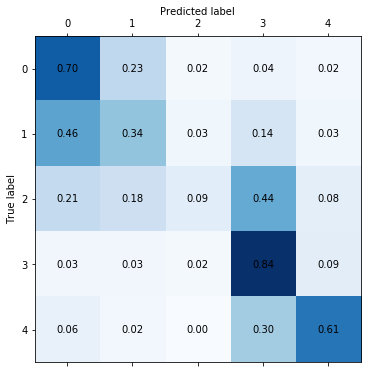

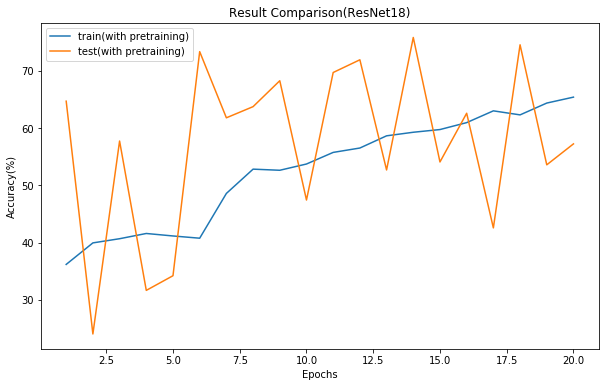

In [11]:
"""
resnet18 without pretrained weights
"""
'''
model_wo=ResNet18(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet18_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet18 (wo pretrained weights).png')
'''
"""
resnet18 with pretrained weights
    feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet18(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay_feature_extraction)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet18_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay_finetuning)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet18_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
#figure.savefig('ResNet18 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_with_pretrained,'Result Comparison(ResNet18)')
figure.savefig('Result Comparison(ResNet18).png')

In [12]:
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  36.179223  64.697509
1       2  39.940923  24.028470
2       3  40.670486  57.736655
3       4  41.585110  31.644128
4       5  41.150931  34.206406
5       1  40.759458  73.352313
6       2  48.581800  61.793594
7       3  52.823944  63.743772
8       4  52.628207  68.270463
9       5  53.720773  47.430605
10      6  55.749315  69.708185
11      7  56.514467  71.928826
12      8  58.646215  52.683274
13      9  59.269013  75.829181
14     10  59.742340  54.078292
15     11  60.952347  62.590747
16     12  63.009360  42.562278
17     13  62.304708  74.548043
18     14  64.368839  53.580071
19     15  65.404463  57.238434


## Run ResNet50

In [13]:
batch_size=8

In [14]:
dataset_train=RetinopathyDataSet(img_path='data',mode='train')
loader_train=DataLoader(dataset=dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

dataset_test=RetinopathyDataSet(img_path='data',mode='test')
loader_test=DataLoader(dataset=dataset_test,batch_size=batch_size,shuffle=False,num_workers=4)

>> Found 28099 images...
>> Found 7025 images...


epoch 1 loss:0.2130 acc:43.51%
epoch 2 loss:0.2061 acc:45.34%
epoch 3 loss:0.2041 acc:45.30%
epoch 4 loss:0.2038 acc:45.67%
epoch 5 loss:0.2006 acc:46.13%
epoch 1 loss:0.1641 acc:59.76%
epoch 2 loss:0.1449 acc:66.75%
epoch 3 loss:0.1382 acc:68.82%
epoch 4 loss:0.1330 acc:70.74%
epoch 5 loss:0.1308 acc:70.70%
epoch 6 loss:0.1271 acc:70.83%
epoch 7 loss:0.1254 acc:71.10%
epoch 8 loss:0.1227 acc:72.21%
epoch 9 loss:0.1216 acc:72.38%
epoch10 loss:0.1203 acc:71.91%
epoch11 loss:0.1181 acc:71.64%
epoch12 loss:0.1168 acc:71.89%
epoch13 loss:0.1151 acc:72.19%
epoch14 loss:0.1145 acc:72.27%
epoch15 loss:0.1146 acc:72.86%


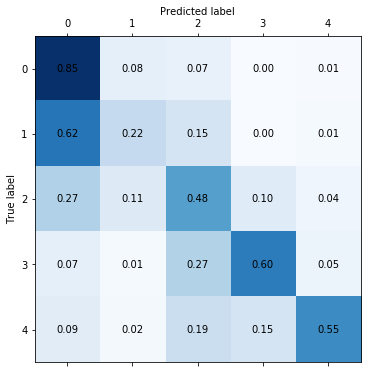

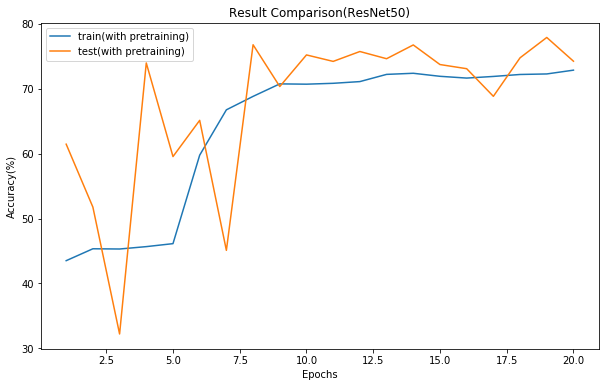

In [15]:
"""
resnet50 without pretrained weights
"""
'''
model_wo=ResNet50(num_class=num_class,pretrained=False)
optimizer=optim.SGD(model_wo.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)
df_wo_pretrained=train(model_wo,loader_train,loader_test,Loss,optimizer,epochs,device,num_class,'resnet50_wo_pretraining')
# test and save confusion matrix figure
confusion_matrix,_=evaluate(model_wo,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
figure.savefig('ResNet50 (wo pretrained weights).png')
'''
"""
resnet50 with pretrained weights
    first feature extraction for few epochs, then finefuning for some epochs
"""
model_with=ResNet50(num_class=num_class,pretrained=True)
# feature extraction
params_to_update=[]
for name,param in model_with.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
optimizer=optim.SGD(params_to_update,lr=lr,momentum=momentum,weight_decay=weight_decay_feature_extraction)
df_firststep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_feature_extraction,device,num_class,'resnet50_with_pretraining')
# finetuning
for param in model_with.parameters():
    param.requires_grad=True
optimizer=optim.SGD(model_with.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay_finetuning)
df_secondstep=train(model_with,loader_train,loader_test,Loss,optimizer,epochs_fine_tuning,device,num_class,'resnet50_with_pretraining')
df_with_pretrained=pd.concat([df_firststep,df_secondstep],axis=0,ignore_index=True)

# test and get a confusion matrix
confusion_matrix,_=evaluate(model_with,loader_test,device,num_class)
figure=plot_confusion_matrix(confusion_matrix)
#figure.savefig('ResNet50 (with pretrained weights).png')

"""
plot accuracy figure
"""
figure=plot(df_with_pretrained,'Result Comparison(ResNet50)')
figure.savefig('Result Comparison(ResNet50).png')

In [16]:
print(df_with_pretrained)

    epoch  acc_train   acc_test
0       1  43.506886  61.451957
1       2  45.339692  51.758007
2       3  45.304103  32.213523
3       4  45.670664  73.964413
4       5  46.129756  59.544484
5       1  59.760134  65.124555
6       2  66.746148  45.096085
7       3  68.817396  76.768683
8       4  70.742731  70.334520
9       5  70.696466  75.202847
10      6  70.831702  74.206406
11      7  71.095057  75.729537
12      8  72.205417  74.619217
13      9  72.376241  76.740214
14     10  71.910032  73.722420
15     11  71.636001  73.081851
16     12  71.888679  68.825623
17     13  72.191181  74.761566
18     14  72.273035  77.893238
19     15  72.856685  74.234875
